# Data Exploration to grasp how different sets of parameters and dimentions of the hypercube work together

In [2]:
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import csv
import numpy as np
from dataclasses import dataclass
import pandas as pd

In [3]:
fieldnames = ["entries", "size", "dimentions", "N", "ecd_time", "ecd_size", "query_gen_time", "query_size", "query_size_no_evt_keys", "answer_gen_time", "answer_size", "answer_get_time", "online_time", "online_time_no_evt_keys", "baseline", "withTLS", "DL", "UL", "leakedBits", "informationBits"]

path = "pirGoExpTLS.csv"
path_wp = "pirGoWPTLS.csv"

all_entries = []
all_sizes = []
all_N = []
all_D = []
all_bw = []

def load_data(path):
    df = pd.read_csv(path)
    return df

In [78]:
# load data
df_pir = load_data(path)
df_wpir = load_data(path_wp)
df = pd.concat([df_pir, df_wpir])
print(df)

      entries  size  dimentions   N    ecd_time     ecd_size  query_gen_time  \
0      262144    30           3  14    0.765062     11281923        0.013210   
1      262144    30           3  14    0.765062     11281923        0.013210   
2      262144    30           3  14    0.765062     11281923        0.013210   
3      262144    30           2  14    0.892265     11280217        0.008166   
4      262144    30           2  14    0.892265     11280217        0.008166   
..        ...   ...         ...  ..         ...          ...             ...   
211  33554432  1000           3  13  131.397607  45012095582        0.001057   
212  33554432  1000           3  13  131.397607  45012095582        0.001057   
213  33554432  1000           2  13  114.146282  45011721605        0.001742   
214  33554432  1000           2  13  114.146282  45011721605        0.001742   
215  33554432  1000           2  13  114.146282  45011721605        0.001742   

     query_size  query_size_no_evt_keys

In [56]:
all_entries = df['entries'].unique()
all_sizes = df['size'].unique()
all_N = df['N'].unique()
all_D = df['dimentions'].unique()
all_bw = df["DL"].unique()

In [5]:
def filter_by_attribs(df : pd.DataFrame, attribs, values)->pd.DataFrame:
    for a,v in zip(attribs, values):
        df = df[df[a] == v]
    return df

## For a given actual db num of entries, for a given db item size, how the different combinations of BFV params and Hypercube Dimention perform? We focus on the full PIR for now

In [61]:
@dataclass
class Performance:
    leakage : float
    online_time : float
    online_time_no_keys : float
    baseline : float
    network_cost : float
    network_cost_no_keys : float

In [ ]:



plt.subplots_adjust(wspace=1, hspace=1.0)

bar_width = 0.3
offset = bar_width
figsize = (15, 20)  # increased figure size

for i, entries in enumerate(all_entries):
    for j, size in enumerate(all_sizes):
        # restrain to 25 Mbps
        filtered_df = filter_by_attribs(df, ["entries", "size", "DL", "leakedBits"], [entries, size, 25.0, 0.0])
        performances = {}
        for _, row in filtered_df.iterrows():
            performances[f"log(n):{row['N']}, d:{row['dimentions']}"] = Performance(
                leakage=float(row['leakedBits']) / float(row['informationBits']),
                online_time=row['online_time'],
                online_time_no_keys=row["online_time_no_evt_keys"],
                baseline=row['baseline'],
                network_cost=float(row['query_size']) + float(row['answer_size']),
                network_cost_no_keys=float(row['query_size_no_evt_keys']) + float(row['answer_size'])
            )
            
        x = np.arange(len(performances))
        leakage = [v.leakage for _, v in performances.items()]
        online_time = [v.online_time for _, v in performances.items()]
        online_time_no_keys = [v.online_time_no_keys for _, v in performances.items()]
        baseline = [v.baseline for _, v in performances.items()][0]
        network_cost = [v.network_cost / 1e6 for _, v in performances.items()]
        network_cost_no_keys = [v.network_cost_no_keys / 1e6 for _, v in performances.items()]

        num_figs = 3
        if all([v == 0.0 for v in leakage]):
            num_figs = 2

        fig, axs = plt.subplots(num_figs, figsize=figsize)
        fig.suptitle(f"Performance entries {entries}, size {size}")

        axs_i = 0
        if num_figs == 3:
            axs[axs_i].set_title("leakage")
            rects = axs[axs_i].bar(x, leakage, width=bar_width, label="leakage")
            axs[axs_i].set_xticks(x)
            axs[axs_i].set_xticklabels(performances.keys())
            axs[axs_i].bar_label(rects, padding=3)
            axs_i += 1

        axs[axs_i].set_title("Online time in log scale (s)")
        rects = axs[axs_i].bar(x, online_time, width=bar_width, label="online_time")
        axs[axs_i].bar_label(rects, padding=3)
        rects = axs[axs_i].bar(x + offset, online_time_no_keys, width=bar_width, label="online_time_no_keys")
        axs[axs_i].bar_label(rects, padding=3)
        axs[axs_i].axhline(baseline, color='green', label="TLS baseline", linestyle='dashed', lw="2")
        yticks = [*ax.get_yticks(), baseline]
        yticklabels = [*ax.get_yticklabels(), baseline]
        axs[axs_i].set_yticks(yticks, labels=yticklabels)
        #rects = axs[axs_i].bar(x + 2*offset, baseline, width=bar_width, label="TLS baseline")
        #axs[axs_i].bar_label(rects, padding=3)
        axs[axs_i].set_xticks(x)
        axs[axs_i].set_xticklabels(performances.keys())
        axs[axs_i].set_yscale('log')  # set y-axis scale to log

        axs_i += 1
        axs[axs_i].set_title("Network Cost (MB)")
        rects = axs[axs_i].bar(x, network_cost, width=bar_width, label="network_cost")
        axs[axs_i].bar_label(rects, padding=3)
        rects = axs[axs_i].bar(x + 1*offset, network_cost_no_keys, width=bar_width, label="network_cost_no_keys")
        axs[axs_i].bar_label(rects, padding=3)
        axs[axs_i].set_xticks(x)
        axs[axs_i].set_xticklabels(performances.keys())

        for ax in axs:
            ax.legend(loc='upper right', ncols=len(x))

plt.show()




### We find that logN = 13 yields better results. We analyze this results

In [47]:
QUERY_SIZE = {
    "d=2" : 8 * 2 * 1<<13,
    "d=3" : 8 * 3 * 1<<13
}

ANSWER_SIZE = 2 * 8 * 1 << 13

In [25]:
def get_time_no_keys(row):
    """ Gets expected time taking into account minimal serialization of data """
    return row["query_gen_time"] + row["answer_gen_time"] + row["answer_get_time"] + (QUERY_SIZE[f"d={int(row['dimentions'])}"] + ANSWER_SIZE)*8/(row["DL"]*1e6)

def get_network_cost_no_keys(row):
    """ Gets expected network cost taking into account minimal serialization of data """
    return QUERY_SIZE[f"d={int(row['dimentions'])}"] + round(row['answer_size']/ANSWER_SIZE)*ANSWER_SIZE

## Comparing Indexed MulPIR and Our Implementation

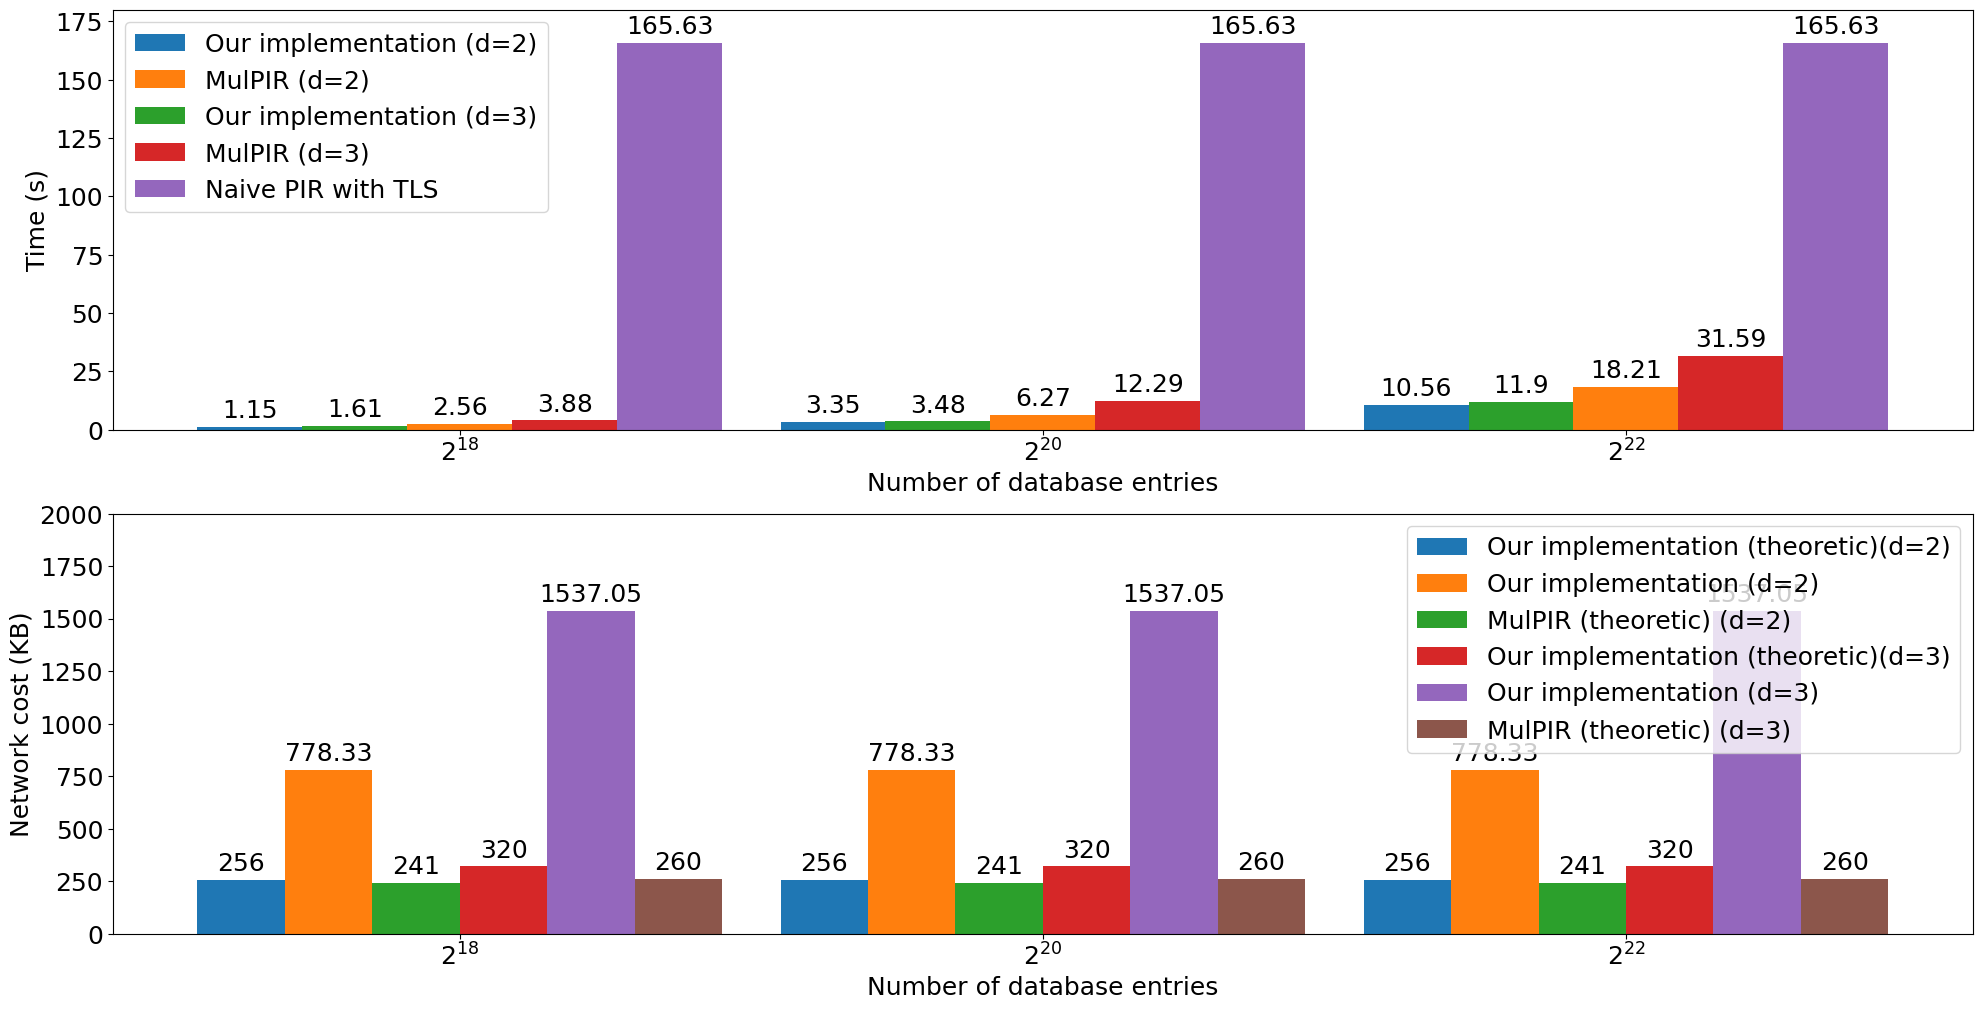

In [98]:
RELATED_WORKS = {
    "MulPIR": {
        "d=2": {
            "n=262144": {
                "time": 1919+391+172,
                "ul": 122*1024,
                "dl": 119*1024,
            },
            "n=1048576": {
                "time": 5213+783+192,
                "ul": 122*1024,
                "dl": 119*1024,
            },
            "n=4194304": {
                "time": 16307+1610+213,
                "ul": 122*1024,
                "dl": 119*1024,
            },
        },
        "d=3": {
            "n=262144": {
                "time": 126+396+3268,
                "ul": 130*1024,
                "dl": 130*1024,
            },
            "n=1048576": {
                "time": 128+395+11677,
                "ul": 130*1024,
                "dl": 130*1024,
            },
            "n=4194304": {
                "time": 30501+841+161,
                "ul": 130*1024,
                "dl": 130*1024,
            },
        },
    },
}

idx_pir_df = load_data("idxpirGoExpTLS.csv")

performances = {}
x = [1<<18, 1<<20, 1<<22]
size = 0
bw = 25.0

for d in [2,3]:
    performances[f"d={d}"] = {}
    for entries in x:
        performances[f"d={d}"][f"n={entries}"] = {}
        filtered_df = filter_by_attribs(idx_pir_df, ["entries", "dimentions","DL"], [entries, d, bw])
        for _, row in filtered_df.iterrows():
            performances[f"d={int(row['dimentions'])}"][f"n={entries}"] = Performance(
                leakage=0.0,
                network_cost=row["query_size_no_evt_keys"]+row["answer_size"],
                online_time=0.0,
                online_time_no_keys=get_time_no_keys(row),
                baseline=row['baseline'],
                network_cost_no_keys=get_network_cost_no_keys(row)
            )
            size = int(row['size'])

fig, axs = plt.subplots(2, figsize=(24,12))
X = np.arange(len(x))
bar_width = 0.18
offset = bar_width
mult_offset = -2.0

for d_idx, d in enumerate([2, 3]):
    ax = axs[0]

    # Our implementation time
    p = performances[f"d={d}"]
    time = []
    baseline = []
    for _, v in p.items():
        time.append(round(v.online_time_no_keys,2))
        baseline.append(v.baseline)

    baseline = [round(sum(baseline)/len(baseline),2) for _ in range(0, len(baseline))]
    rects = ax.bar(X + mult_offset * offset, time, width=bar_width, label=f"Our implementation (d={d})")
    ax.bar_label(rects, padding=3)

    # MulPIR time
    r = RELATED_WORKS["MulPIR"][f"d={d}"]
    time_to_compare = []
    for _, v in r.items():
        time_to_compare.append(round(v["time"] / 1000 + v["ul"] * 8 / (bw * 1e6) + v["dl"] * 8 / (bw * 1e6),2))
    rects = ax.bar(X + (mult_offset + 2) * offset, time_to_compare, width=bar_width, label=f"MulPIR (d={d})")
    ax.bar_label(rects, padding=3)

    mult_offset += 1

# Baseline time
rects = ax.bar(X + (mult_offset + 2) * offset, baseline, width=bar_width, label=f"Naive PIR with TLS")
ax.bar_label(rects, padding=3)
ax.set_xticks(X, x)
ax.set_xticklabels([f"$2^{{18}}$", f"$2^{{20}}$", f"$2^{{22}}$"])
ax.set_xlabel("Number of database entries")
ax.set_ylabel("Time (s)")
ax.set_ylim(top=180)
ax.legend()

# Second subplot: network cost performance
bar_width = 0.15
offset = bar_width
mult_offset = -2.5

for d_idx, d in enumerate([2, 3]):
    ax = axs[1]

    # Our implementation time
    p = performances[f"d={d}"]
    netw = []
    netw_go = []
    for _, v in p.items():
        netw_go.append(round(v.network_cost/ 1024,2))
        netw.append(round(v.network_cost_no_keys / 1024,2))
    rects = ax.bar(X + mult_offset * offset, netw, width=bar_width, label=f"Our implementation (theoretic)(d={d})")
    ax.bar_label(rects, padding=3)
    rects = ax.bar(X + (mult_offset+1) * offset, netw_go, width=bar_width, label=f"Our implementation (d={d})")
    ax.bar_label(rects, padding=3)

    r = RELATED_WORKS["MulPIR"][f"d={d}"]
    netw_to_compare = []
    for _, v in r.items():
        netw_to_compare.append(round((v["ul"] + v["dl"])/1024,2))
    rects = ax.bar(X + (mult_offset + 2) * offset, netw_to_compare, width=bar_width, label=f"MulPIR (theoretic) (d={d})")
    ax.bar_label(rects, padding=3)

   

    ax.set_xticks(X, x)
    ax.set_xticklabels([f"$2^{{18}}$", f"$2^{{20}}$", f"$2^{{22}}$"])
    ax.set_xlabel("Number of database entries")
    ax.set_ylabel("Network cost (KB)")
    ax.set_ylim(top=2000)
    ax.legend()

    mult_offset += 3


plt.rcParams.update({'font.size': 18})
plt.show()


## Comparing Sparse-MulPIR and Our implementation

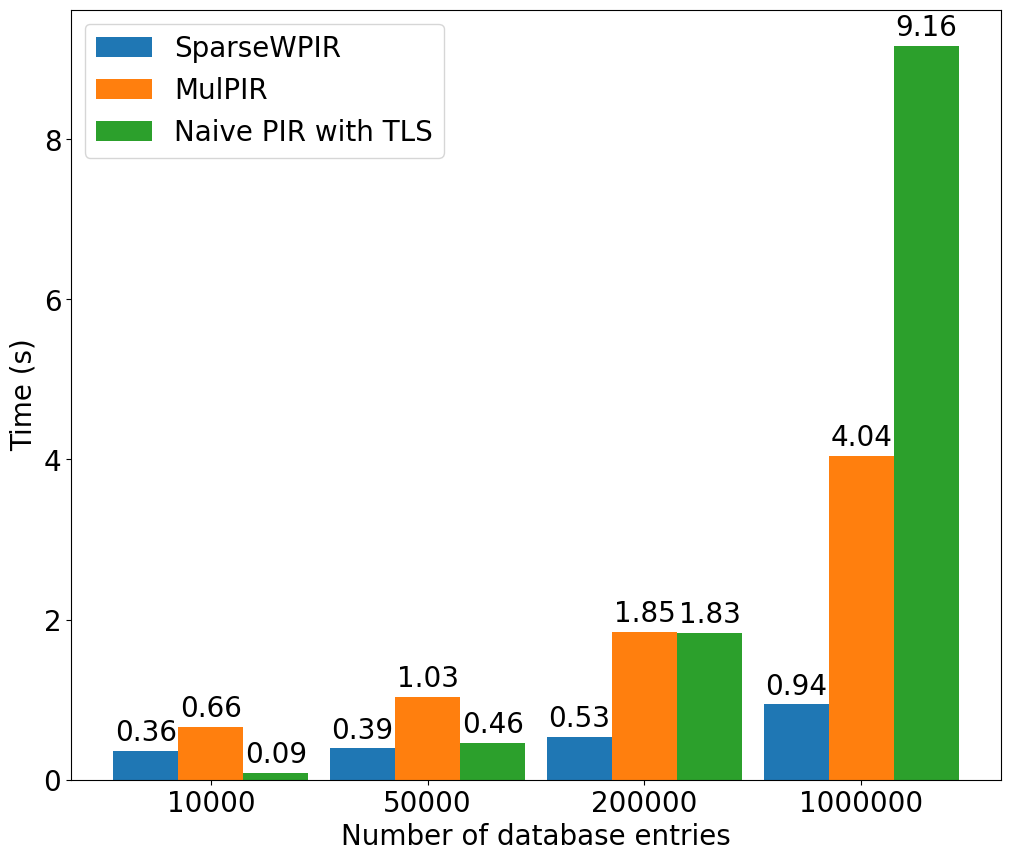

In [268]:
RELATED_WORKS = {
    "MulPIR":{
        "n=10000":{
            "time":156+475,
            "comm":90.5*1024,
            },
        "n=50000":{
            "time":195+810,
            "comm":90.5*1024,
            },
        "n=200000":{
            "time":236+1588,
          "comm":90.5*1024,
            },
        "n=1000000":{
            "time":265+3742,
            "comm":90.5*1024,
            },
    }
}

sparse_pir_df = load_data("pirGoExp_vs_mulPIR.csv")

performances = {}
x = [10*1000, 50*1000, 200*1000, 1000*1000]
size = 0
bw = 25.0
for entries in x:
    performances[f"n={entries}"] = {}
    filtered_df = filter_by_attribs(sparse_pir_df, ["entries","DL"], [entries, bw])
    for _, row in filtered_df.iterrows():
        performances[f"n={entries}"] = Performance(
            leakage=0.0,
            network_cost=0.0,
            online_time=0.0,
            online_time_no_keys=get_time_no_keys(row),
            baseline=row['baseline'],
            network_cost_no_keys=get_network_cost_no_keys(row),
        )
        size = int(row['size'])

X = np.arange(len(x))
bar_width = 0.3
offset = bar_width
mult_offset = -1.0

fig = plt.figure(figsize=(12,10))
#plt.title(f"Benchmark of Keyword-MulPIR and SparseWPIR (with no leakage)")

time = []
baseline = []
for _, v in performances.items():
    time.append(round(v.online_time_no_keys,2))
    baseline.append(round(v.baseline,2))

rects = plt.bar(X + mult_offset * offset, time, width=bar_width, label=f"SparseWPIR")
plt.bar_label(rects, padding=3)

r = RELATED_WORKS["MulPIR"]
time_to_compare = []
for _, v in r.items():
    time_to_compare.append(round(v["time"] / 1000 + v["comm"] * 8 / (bw * 1e6),2))
rects = plt.bar(X + (mult_offset + 1) * offset, time_to_compare, width=bar_width, label=f"MulPIR")
plt.bar_label(rects, padding=3)
mult_offset += 1

# Baseline time
rects = plt.bar(X + (mult_offset + 1) * offset, baseline, width=bar_width, label=f"Naive PIR with TLS")
plt.bar_label(rects, padding=3)

plt.xticks(X, x)
plt.xlabel("Number of database entries")
plt.ylabel("Time (s)")
plt.legend()

plt.show()

## Context approximations benchmark

{'old': {'d=2': {'n=65536': Performance(leakage=0.0, online_time=0.0, online_time_no_keys=1.1914110800000004, baseline=0.0, network_cost=0.0, network_cost_no_keys=262.144), 'n=262144': Performance(leakage=0.0, online_time=0.0, online_time_no_keys=2.3844960800000004, baseline=0.0, network_cost=0.0, network_cost_no_keys=262.144), 'n=1048576': Performance(leakage=0.0, online_time=0.0, online_time_no_keys=6.8220060799999995, baseline=0.0, network_cost=0.0, network_cost_no_keys=262.144)}, 'd=3': {'n=65536': Performance(leakage=0.0, online_time=0.0, online_time_no_keys=0.6378056, baseline=0.0, network_cost=0.0, network_cost_no_keys=327.68), 'n=262144': Performance(leakage=0.0, online_time=0.0, online_time_no_keys=1.7081396, baseline=0.0, network_cost=0.0, network_cost_no_keys=327.68), 'n=1048576': Performance(leakage=0.0, online_time=0.0, online_time_no_keys=6.039627599999999, baseline=0.0, network_cost=0.0, network_cost_no_keys=327.68)}}, 'new': {'d=2': {'n=65536': Performance(leakage=0.0, 

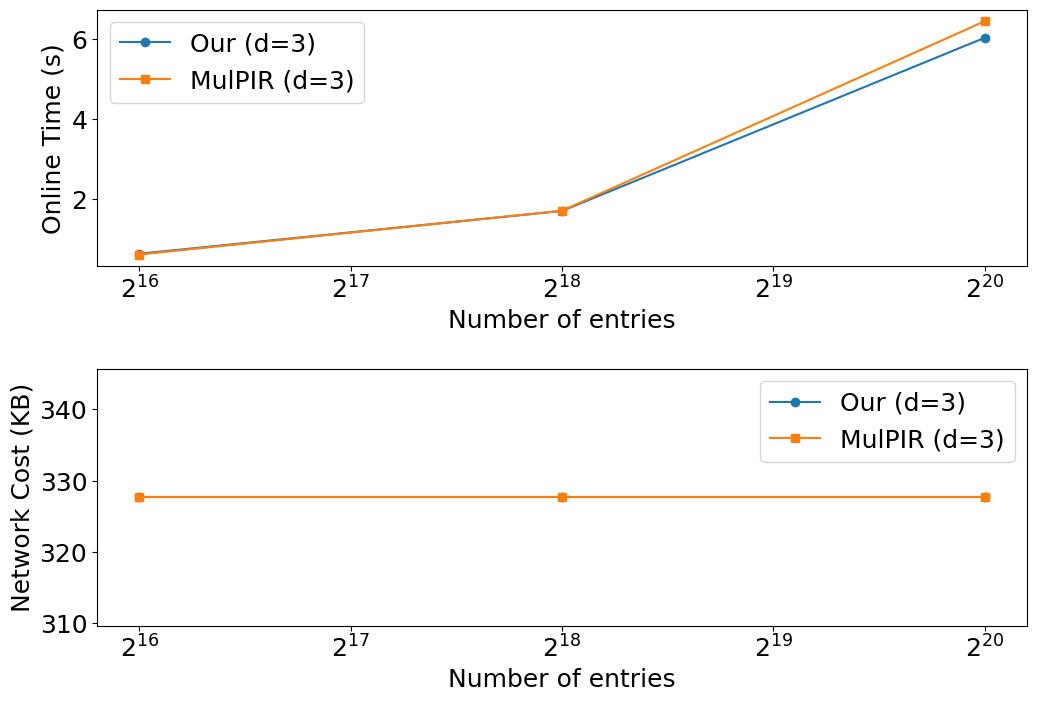

In [219]:
old_ctx = load_data("pirGoExp_oldCtx.csv")
new_ctx = load_data("pirGoExp_newCtx.csv")

performances = {"old":{}, "new":{}}
x = [1<<16, 1<<18, 1<<20]
bw = 25.0

for s,df in zip(["old","new"], [old_ctx, new_ctx]):
    for d in [2,3]:
        performances[s][f"d={d}"] = {}
        for entries in x:
            performances[s][f"d={d}"][f"n={entries}"] = {}
            filtered_df = filter_by_attribs(df, ["entries", "dimentions","DL"], [entries, d, bw])
            for _, row in filtered_df.iterrows():
                performances[s][f"d={int(row['dimentions'])}"][f"n={entries}"] = Performance(
                    leakage=0.0,
                    network_cost=0.0,
                    online_time=0.0,
                    online_time_no_keys=get_time_no_keys(row),
                    baseline=0.0,
                    network_cost_no_keys=get_network_cost_no_keys(row)/1e3,
                )
print(performances)

# Define the data to plot
old_online_times_d2 = [performances["old"]["d=2"][f"n={entries}"].online_time_no_keys for entries in x]
old_online_times_d3 = [performances["old"]["d=3"][f"n={entries}"].online_time_no_keys for entries in x]
new_online_times_d2 = [performances["new"]["d=2"][f"n={entries}"].online_time_no_keys for entries in x]
new_online_times_d3 = [performances["new"]["d=3"][f"n={entries}"].online_time_no_keys for entries in x]

old_network_costs_d2 = [performances["old"]["d=2"][f"n={entries}"].network_cost_no_keys for entries in x]
old_network_costs_d3 = [performances["old"]["d=3"][f"n={entries}"].network_cost_no_keys for entries in x]
new_network_costs_d2 = [performances["new"]["d=2"][f"n={entries}"].network_cost_no_keys for entries in x]
new_network_costs_d3 = [performances["new"]["d=3"][f"n={entries}"].network_cost_no_keys for entries in x]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Set the spacing between the subplots
fig.subplots_adjust(hspace=0.4)

# Plot the online_time for the old and new contexts for d=2
ax1.plot(x, old_online_times_d2, label="Our (d=2)", marker="o")
ax1.plot(x, new_online_times_d2, label="MulPIR (d=2)", marker="s")
# Plot the online_time for the old and new contexts for d=2
ax1.plot(x, old_online_times_d3, label="Our (d=3)", marker="o")
ax1.plot(x, new_online_times_d3, label="MulPIR (d=3)", marker="s")

# Add labels and legend to the first subplot
ax1.set_xscale('log', base=2)
ax1.set_xlabel("Number of entries")
ax1.set_ylabel("Online Time (s)")
ax1.legend()

# Plot the network_cost for the old and new contexts for d=2
ax2.plot(x, old_network_costs_d2, label="Our (d=2)", marker="o")
ax2.plot(x, new_network_costs_d2, label="MulPIR (d=2)", marker="s")
# Plot the network_cost for the old and new contexts for d=2
ax2.plot(x, old_network_costs_d3, label="Our (d=3)", marker="o")
ax2.plot(x, new_network_costs_d3, label="MulPIR (d=3)", marker="s")

# Add labels and legend to the second subplot
ax2.set_xscale('log', base=2)
ax2.set_xlabel("Number of entries")
ax2.set_ylabel("Network Cost (KB)")
ax2.legend()

plt.show()

## Benefits of running on multiple cores

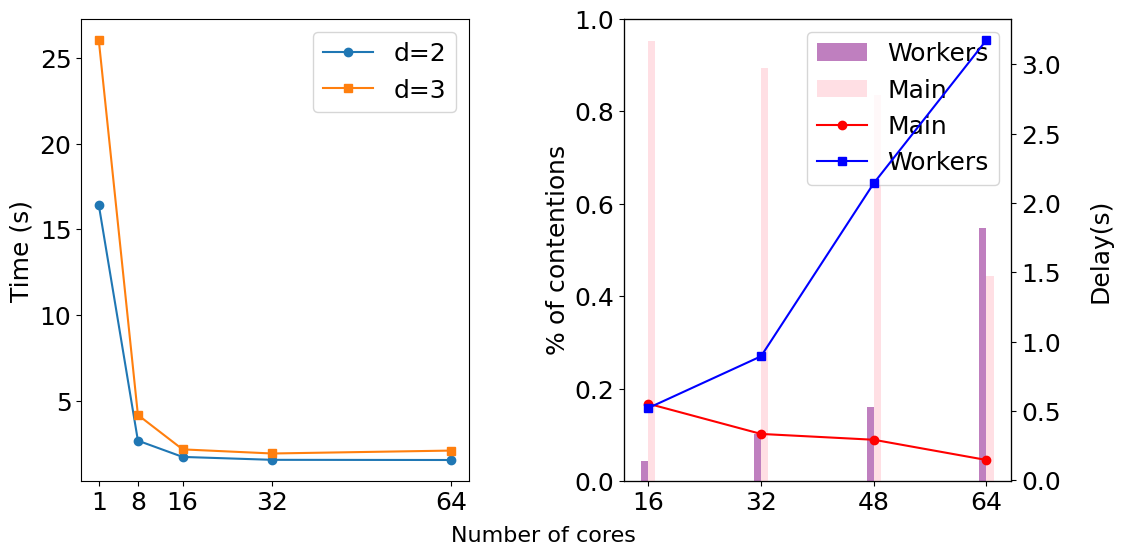

In [209]:
x = [1, 8, 16, 32, 64]
performances = {"d=2": [], "d=3": []}

# Load and filter the data
for cores in x:
    df = load_data(f"pirGoExp_{cores}core.csv")
    for d in [2, 3]:
        filtered_df = filter_by_attribs(df, ["N", "dimentions"], [13, d])
        for _, row in filtered_df.iterrows():
            performances[f"d={d}"].append(round(row["answer_gen_time"], 2))
            break

# Create the first subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Set the spacing between the two subplots
fig.subplots_adjust(wspace=0.4)
# Plot the data for the first subplot
ax1.plot(x, performances["d=2"], label="d=2", marker="o")
ax1.plot(x, performances["d=3"], label="d=3", marker="s")

# Add labels and legend to the first subplot
ax1.set_xticks(x)
#ax1.set_xlabel("Number of cores")
ax1.set_ylabel("Time (s)")
ax1.legend()

# Define the data for the second subplot
x2 = [16, 32, 48, 64]
main_thread = {'contentions':[95.46, 89.65, 83.69, 44.49],'delay':[0.553, 0.335, 0.293, 0.147]}
worker_threads = {'contentions':[4.32, 10.1, 16.01, 54.89],'delay':[0.522, 0.895, 2.143, 3.176]}

# Plot the data for the second subplot
ax2_1 = ax2.twinx()
ax2_2 = ax2.twinx()

# Decrease the offset of the second subplot
offset = 0.2

# Increase the width of the bars
width = 1

# Plot the bars for the second subplot side by side
ax2_1.bar([x - width/2 for x in x2], worker_threads["contentions"], width=width, color='purple', alpha=0.5, label="Workers")
ax2_1.bar([x + width/2 for x in x2], main_thread["contentions"], width=width, color='pink', alpha=0.5, label="Main")
ax2.set_xticks(x2)
ax2_1.set_ylabel("Delay(s)")
ax2_1.yaxis.set_label_coords(1.2, 0.5)
ax2_1.set_yticks([])
#ax2_1.set_ylim(0, 100)

# Move the "Delay(s)" label to the left of the second subplot
ax2_2.set_ylabel("$\%$ of contentions")
ax2_2.yaxis.set_label_coords(-0.2, 0.5)

ax2_2.plot(x2, [t for t in main_thread["delay"]], 'r', marker='o', label="Main")
ax2_2.plot(x2, [t for t in worker_threads["delay"]], 'b', marker='s', label="Workers")

# Set the ticks on the right y-axis
ax2_2.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])

# Merge the legends for the second subplot
lines, labels = ax2_1.get_legend_handles_labels()
lines2, labels2 = ax2_2.get_legend_handles_labels()
ax2_1.legend(lines + lines2, labels + labels2, loc='upper right')

# Add a common x-label to both subplots
fig.text(0.51, 0.01, 'Number of cores', ha='center', fontsize=16)

plt.show()


## Evaluating different level of leakages

{10: {'0': {0.0: 1.712961, 0.02: 2.16543, 0.07: 3.817273, 0.13: 4.129619, 1.21: 25.767402, 4.19: 127.41762, 1.01: 23.178976, 9.66: 231.652351, 33.55: 488.801192}, '1': {0.0: 0.9339, 0.02: 0.986319, 0.07: 1.068203, 0.13: 1.058119, 1.21: 10.163888, 4.19: 2.171291, 1.01: 1.279591, 9.66: 3.547813, 33.55: 3.388353}, '2': {0.0: 0.542572, 0.02: 0.515153, 0.07: 0.530125, 0.13: 0.658738, 1.21: 0.5753, 4.19: 0.663219, 1.01: 0.724395, 9.66: 0.749629, 33.55: 0.987312}}, 25: {'0': {0.0: 0.99247, 0.02: 1.444937, 0.07: 3.096781, 0.13: 3.409124, 1.21: 25.046908, 4.19: 126.697126, 1.01: 22.458481, 9.66: 230.931856, 33.55: 487.92062}, '1': {0.0: 0.569057, 0.02: 0.621475, 0.07: 0.703359, 0.13: 0.693274, 1.21: 9.799043, 4.19: 1.806444, 1.01: 0.914744, 9.66: 3.182966, 33.55: 2.943468}, '2': {0.0: 0.391163, 0.02: 0.363743, 0.07: 0.378715, 0.13: 0.507327, 1.21: 0.423888, 4.19: 0.511806, 1.01: 0.572982, 9.66: 0.598217, 33.55: 0.75586}}, 50: {'0': {0.0: 0.752306, 0.02: 1.204773, 0.07: 2.856616, 0.13: 3.16896, 

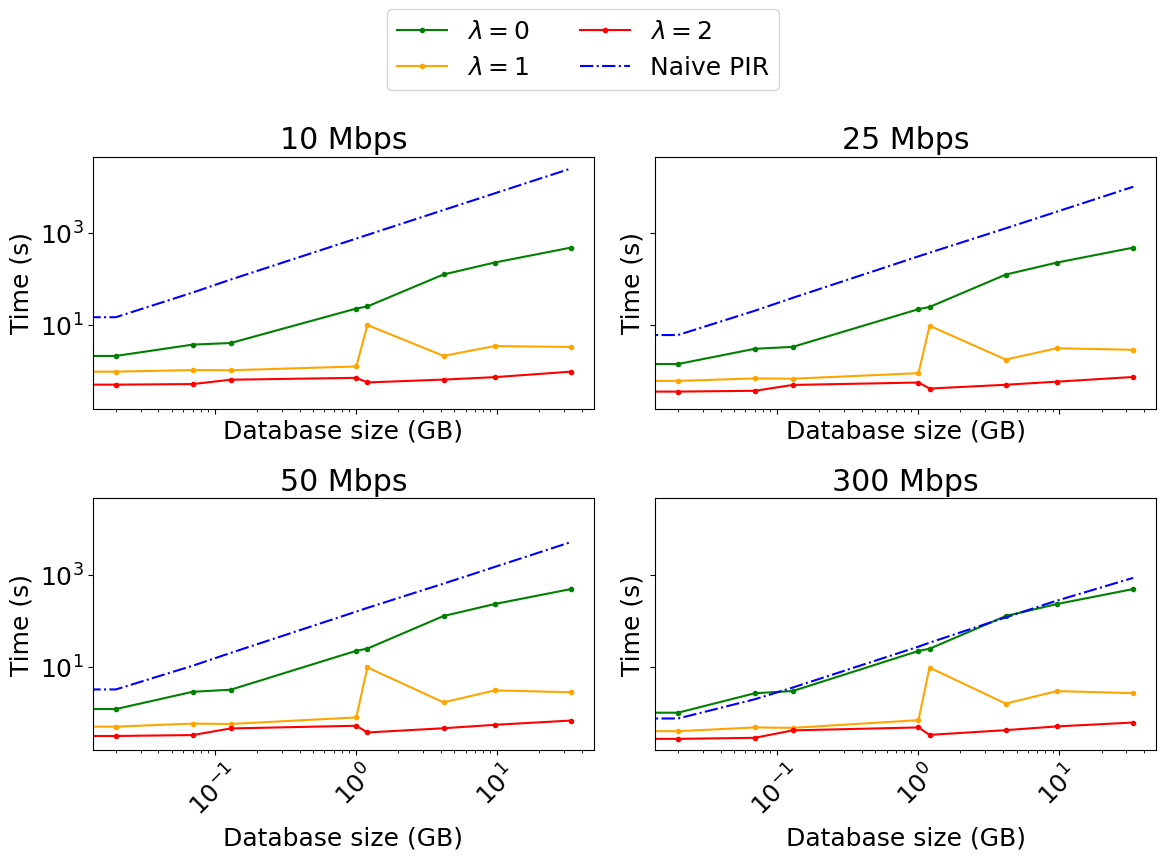

In [129]:
CSV = {"0": "pirGoExpTLS.csv", "1": "pirGoWPTLS.csv", "2": "pirGoWP2TLS.csv"}

x_values = {} #set of different db sizes
performances = {10:{"0":{},"1":{},"2":{}},25:{"0":{},"1":{},"2":{}}, 50:{"0":{},"1":{},"2":{}}, 300:{"0":{},"1":{},"2":{}}} #maps bandwidth values to dict{leakage value -> dict{database_size: runtime}}
baselines = {10:{"0":{},"1":{},"2":{}},25:{"0":{},"1":{},"2":{}},50:{"0":{},"1":{},"2":{}}, 300:{"0":{},"1":{},"2":{}}}

i = 0
for leakage, path in CSV.items():
    df = load_data(path)
    df = filter_by_attribs(df, ["N","dimentions"], [13,3])
    for _, row in df.iterrows():

        performance_of_bw = performances[int(row["DL"])]
        db_size = round(row["entries"]*row["size"] / 1e9,2) #GB
        x_values[db_size] = True
        performance_of_bw[leakage][db_size] = row["online_time_no_evt_keys"]
        performances[int(row["DL"])] = performance_of_bw
        baselines[int(row["DL"])][leakage][db_size] = row["baseline"]
        

print(performances)
print(baselines)

#performances = {10: {'0': {7.86432: 0.873747, 75.497472: 1.624135, 262.144: 5.719496, 31.45728: 1.00271, 301.989888: 4.488088, 1048.576: 21.356067, 1006.63296: 15.417724, 9663.676416: 161.43498300000002, 33554.432: 373.825896}, '1': {7.86432: 0.39317, 75.497472: 0.39459299999999997, 262.144: 0.46861299999999995, 31.45728: 0.47379, 301.989888: 0.5216080000000001, 1048.576: 0.38137, 1006.63296: 0.46150199999999997, 9663.676416: 0.487979, 33554.432: 0.781936}, '2': {7.86432: 0.39317, 75.497472: 0.39459299999999997, 262.144: 0.46861299999999995, 31.45728: 0.47379, 301.989888: 0.5216080000000001, 1048.576: 0.38137, 1006.63296: 0.46150199999999997, 9663.676416: 0.487979, 33554.432: 0.781936}}, 25: {'0': {7.86432: 0.7164606, 75.497472: 1.4668486, 262.144: 5.5622096, 31.45728: 0.8454235999999999, 301.989888: 4.3308016, 1048.576: 21.1987806, 1006.63296: 15.260437600000001, 9663.676416: 161.2776966, 33554.432: 373.6686096}, '1': {7.86432: 0.2358836, 75.497472: 0.23730659999999998, 262.144: 0.3113266, 31.45728: 0.3165036, 301.989888: 0.3643216, 1048.576: 0.2240836, 1006.63296: 0.30421560000000003, 9663.676416: 0.3306926, 33554.432: 0.6246496}, '2': {7.86432: 0.2358836, 75.497472: 0.23730659999999998, 262.144: 0.3113266, 31.45728: 0.3165036, 301.989888: 0.3643216, 1048.576: 0.2240836, 1006.63296: 0.30421560000000003, 9663.676416: 0.3306926, 33554.432: 0.6246496}}, 50: {'0': {7.86432: 0.6640318000000001, 75.497472: 1.4144198000000001, 262.144: 5.509780800000001, 31.45728: 0.7929948, 301.989888: 4.2783728000000005, 1048.576: 21.1463518, 1006.63296: 15.2080088, 9663.676416: 161.2252678, 33554.432: 373.6161808}, '1': {7.86432: 0.1834548, 75.497472: 0.18487779999999998, 262.144: 0.25889779999999996, 31.45728: 0.2640748, 301.989888: 0.3118928, 1048.576: 0.1716548, 1006.63296: 0.2517868, 9663.676416: 0.2782638, 33554.432: 0.5722208}, '2': {7.86432: 0.1834548, 75.497472: 0.18487779999999998, 262.144: 0.25889779999999996, 31.45728: 0.2640748, 301.989888: 0.3118928, 1048.576: 0.1716548, 1006.63296: 0.2517868, 9663.676416: 0.2782638, 33554.432: 0.5722208}}, 300: {'0': {7.86432: 0.6203411333333333, 75.497472: 1.3707291333333336, 262.144: 5.466090133333333, 31.45728: 0.7493041333333332, 301.989888: 4.234682133333333, 1048.576: 21.102661133333335, 1006.63296: 15.164318133333333, 9663.676416: 161.18157713333335, 33554.432: 373.57249013333336}, '1': {7.86432: 0.13976413333333335, 75.497472: 0.14118713333333333, 262.144: 0.21520713333333333, 31.45728: 0.22038413333333334, 301.989888: 0.26820213333333337, 1048.576: 0.12796413333333334, 1006.63296: 0.20809613333333335, 9663.676416: 0.23457313333333335, 33554.432: 0.5285301333333333}, '2': {7.86432: 0.13976413333333335, 75.497472: 0.14118713333333333, 262.144: 0.21520713333333333, 31.45728: 0.22038413333333334, 301.989888: 0.26820213333333337, 1048.576: 0.12796413333333334, 1006.63296: 0.20809613333333335, 9663.676416: 0.23457313333333335, 33554.432: 0.5285301333333333}}}
#baselines = {10: {7.86432: 0.332995, 75.497472: 0.391574, 262.144: 0.401621, 31.45728: 0.382881, 301.989888: 0.474005, 1048.576: 0.477114, 1006.63296: 0.664536, 9663.676416: 0.906171, 33554.432: 1.619429}, 25: {7.86432: 0.287466, 75.497472: 0.313365, 262.144: 0.316918, 31.45728: 0.307042, 301.989888: 0.344148, 1048.576: 0.344887, 1006.63296: 0.420899, 9663.676416: 0.520408, 33554.432: 0.803409}, 50: {'0': {}, '1': {}, '2': {}, 7.86432: 0.270936, 75.497472: 0.282418, 262.144: 0.287634, 31.45728: 0.282914, 301.989888: 0.299285, 1048.576: 0.302728, 1006.63296: 0.337314, 9663.676416: 0.388927, 33554.432: 0.531204}, 300: {7.86432: 0.0262144, 75.497472: 0.25165824, 262.144: 0.8738133333333333, 31.45728: 0.1048576, 301.989888: 1.00663296, 1048.576: 3.4952533333333333, 1006.63296: 3.3554432, 9663.676416: 32.21225472, 33554.432: 111.84810666666667}}
#x_values = baselines[10].keys()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over the bandwidth values and subplots

for i, bw in enumerate([10, 25, 50, 300]):
    ax = axs[i]
    lines = []
    labels = []
    
    # Plot the performances for each leakage profile
    colors = ["green", "orange", "red"]
    for j, leakage in enumerate(["0", "1", "2"]):
        performance_data = performances[bw][leakage]
        
        
        x_values = list(performance_data.keys())
        x_values.sort()
        x = [round(v,2) for v in x_values]
        y = [performance_data[db_size] for db_size in x_values]
        
        label = f"$\lambda={j}$"
        line1, = ax.plot(x, y, label=label, marker='o', color=colors[j],markersize=3)
       
        lines.append(line1)
        labels.append(label)
    
    baseline_data = baselines[bw]["0"]
    y = [baseline_data[db_size] for db_size in x_values]
    line2, = ax.plot(x, y, label=f"Naive PIR - {label}", color="blue", linestyle="-.")
    
    lines.append(line2)
    labels.append(f"Naive PIR")
    
    # Set the axis labels and ticks
    ax.set_xlabel("Database size (GB)")
    ax.set_ylabel("Time (s)")
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation=45)
    ax.set_yticks([10**i for i in range(-2, 7)])
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Set the title
    ax.set_title(f"{bw} Mbps")

# Add the legend outside the subplots
fig.legend(lines, labels, loc='upper center', ncol=len(labels)//2, bbox_to_anchor=(0.5, 1.1))

# Add the overall title and adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()
